# Developing, Training, and Deploying a TensorFlow model on Vertex AI

In this notebook, we will develop a Keras model to predict flight delays using TensorFlow 2.0 as the backend.

In [4]:
import os, json, math, shutil
import numpy as np
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

# environment variables used by bash cells
PROJECT=!(gcloud config get-value project)
PROJECT=PROJECT[0]

###### CHANGE AS NEEDED
REGION = 'us-central1'
BUCKET='{}-dsongcp'.format(PROJECT)
os.environ['ENDPOINT_NAME'] = 'flights'
######

os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TF_VERSION']='2-' + tf.__version__[2:3]  # needed to choose container
print("project:", PROJECT, "bucket:", BUCKET)

Tensorflow version 2.6.0
project: ai-analytics-solutions bucket: ai-analytics-solutions-dsongcp


### Export files that contain training, validation data

The training and validation dataset requires doing a join on several BigQuery tables. Because of this,
we'll need export the data we need to create new tables that are flattened (the BigQueryReader in
TensorFlow needs tables: see https://towardsdatascience.com/how-to-read-bigquery-data-from-tensorflow-2-0-efficiently-9234b69165c8). But if we are going to make a copy of the data, we might as well export the data to
Google Cloud Storage.

In [2]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_train_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'True'

Query complete after 0.01s: 100%|██████████| 4/4 [00:00<00:00, 2441.74query/s]                        


""


In [3]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_eval_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'False'

Query complete after 0.00s: 100%|██████████| 4/4 [00:00<00:00, 2111.40query/s]                        


""


In [5]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_all_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon,
  IF (is_train_day = 'True',
      IF(ABS(MOD(FARM_FINGERPRINT(CAST(f.FL_DATE AS STRING)), 100)) < 60, 'TRAIN', 'VALIDATE'),
      'TEST') AS data_split
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False

Query complete after 0.00s: 100%|██████████| 4/4 [00:00<00:00, 2163.96query/s]                        


""


In [6]:
%%bash
PROJECT=$(gcloud config get-value project)
for dataset in "train" "eval" "all"; do
  TABLE=dsongcp.flights_${dataset}_data
  CSV=gs://${BUCKET}/ch9/data/${dataset}.csv
  echo "Exporting ${TABLE} to ${CSV} and deleting table"
  bq --project_id=${PROJECT} extract --destination_format=CSV $TABLE $CSV
  bq --project_id=${PROJECT} rm -f $TABLE
done

Exporting dsongcp.flights_train_data to gs://ai-analytics-solutions-dsongcp/ch9/data/train.csv and deleting table
BigQuery error in extract operation: Error processing job 'ai-analytics-
solutions:bqjob_r44fc378e3cfd5471_0000017ce851056f_1': Not found: Table ai-
analytics-solutions:dsongcp.flights_train_data was not found in location US
Exporting dsongcp.flights_eval_data to gs://ai-analytics-solutions-dsongcp/ch9/data/eval.csv and deleting table
BigQuery error in extract operation: Error processing job 'ai-analytics-
solutions:bqjob_r636cd98e538171f2_0000017ce8510e6d_1': Not found: Table ai-
analytics-solutions:dsongcp.flights_eval_data was not found in location US
Exporting dsongcp.flights_all_data to gs://ai-analytics-solutions-dsongcp/ch9/data/all.csv and deleting table


Waiting on bqjob_r3b5206a10b46f1bf_0000017ce851171e_1 ... (108s) Current status: DONE   


In [9]:
!gsutil ls -lh gs://{BUCKET}/ch9/data

445.01 MiB  2021-11-04T00:21:29Z  gs://ai-analytics-solutions-dsongcp/ch9/data/all.csv
115.19 MiB  2021-11-02T06:34:16Z  gs://ai-analytics-solutions-dsongcp/ch9/data/eval.csv
296.96 MiB  2021-11-02T06:33:38Z  gs://ai-analytics-solutions-dsongcp/ch9/data/train.csv
TOTAL: 3 objects, 898801258 bytes (857.16 MiB)


## Setup in notebook

For development purposes, we'll train for just a few epochs.
That's why the NUM_EXAMPLES is so low.

In [6]:
DEVELOP_MODE = True
NUM_EXAMPLES = 5000*1000 # doesn't need to be precise but get order of magnitude right.

In [7]:
# use wildcard in the name so that it works even if you have multiple files
training_data_uri = 'gs://{}/ch9/data/train*'.format(BUCKET)
validation_data_uri = 'gs://{}/ch9/data/eval*'.format(BUCKET)

## Model Parameters

In [8]:
NBUCKETS = 5 #
NEMBEDS = 3
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

## Creating the input data pipeline

In [9]:
if DEVELOP_MODE:
    train_df = tf.data.experimental.make_csv_dataset(training_data_uri, batch_size=5)
    for n, data in enumerate(train_df):
        numpy_data = {k: v.numpy() for k, v in data.items()} # .numpy() works only in eager mode
        print(n, numpy_data)
        if n==1: break

2021-11-02 06:36:05.054956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-11-02 06:36:05.055014: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-02 06:36:05.055046: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vm-c1550029-5104-48d2-bb26-0a20bde269bf): /proc/driver/nvidia/version does not exist
2021-11-02 06:36:05.055552: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  

0 {'ontime': array([1, 1, 1, 1, 1], dtype=int32), 'dep_delay': array([-8,  8, 18, -3, -1], dtype=int32), 'taxi_out': array([ 9, 13, 10,  8, 16], dtype=int32), 'distance': array([980, 571, 319, 253, 325], dtype=int32), 'origin': array([b'LBE', b'JNU', b'FLL', b'ANC', b'BUR'], dtype=object), 'dest': array([b'FLL', b'ANC', b'JAX', b'ADQ', b'OAK'], dtype=object), 'dep_hour': array([20, 16,  0,  0, 20], dtype=int32), 'is_weekday': array([1, 1, 1, 0, 1], dtype=int32), 'carrier': array([b'NK', b'AS', b'B6', b'AS', b'WN'], dtype=object), 'dep_airport_lat': array([40.274723, 58.35472 , 26.0725  , 61.174168, 34.200554],
      dtype=float32), 'dep_airport_lon': array([ -79.40667, -134.57834,  -80.15278, -149.99806, -118.35861],
      dtype=float32), 'arr_airport_lat': array([26.0725  , 61.174168, 30.494167, 57.75    , 37.72278 ],
      dtype=float32), 'arr_airport_lon': array([ -80.15278 , -149.99806 ,  -81.687775, -152.4939  , -122.22139 ],
      dtype=float32)}
1 {'ontime': array([1, 0, 1, 1, 0

In [10]:
def features_and_labels(features):
  label = features.pop('ontime') # this is what we will train for
  return features, label

def read_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN, truncate=None):
  dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size)
  dataset = dataset.map(features_and_labels)
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(batch_size*10)
    dataset = dataset.repeat()
  dataset = dataset.prefetch(1)
  if truncate is not None:
    dataset = dataset.take(truncate)
  return dataset


if DEVELOP_MODE:
    print("Checking input pipeline")
    one_item = read_dataset(training_data_uri, batch_size=2, truncate=1)
    print(list(one_item)) # should print one batch of 2 items

Checking input pipeline
[(OrderedDict([('dep_delay', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-11,   9], dtype=int32)>), ('taxi_out', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([10, 10], dtype=int32)>), ('distance', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 539, 1180], dtype=int32)>), ('origin', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'OME', b'RSW'], dtype=object)>), ('dest', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'ANC', b'BDL'], dtype=object)>), ('dep_hour', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([21, 19], dtype=int32)>), ('is_weekday', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>), ('carrier', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'AS', b'B6'], dtype=object)>), ('dep_airport_lat', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([64.51222 , 26.536112], dtype=float32)>), ('dep_airport_lon', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-165.44528,  -81.75528], dtype=float32)>), (

## Create TensorFlow wide-and-deep model

We'll create feature columns, and do some discretization and feature engineering.
See the book for details.

In [11]:
import tensorflow as tf

real = {
    colname : tf.feature_column.numeric_column(colname) 
          for colname in 
            (
                'dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
                'dep_airport_lat,dep_airport_lon,' +
                'arr_airport_lat,arr_airport_lon'
            ).split(',')
}
sparse = {
      'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                  vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(',')),
      'origin' : tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000),
}

inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') 
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') 
          for colname in sparse.keys()
})

### Feature engineering

In [12]:
latbuckets = np.linspace(20.0, 50.0, NBUCKETS).tolist()  # USA
lonbuckets = np.linspace(-120.0, -70.0, NBUCKETS).tolist() # USA
disc = {}
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], latbuckets) 
          for key in ['dep_airport_lat', 'arr_airport_lat']
})
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], lonbuckets) 
          for key in ['dep_airport_lon', 'arr_airport_lon']
})

# cross columns that make sense in combination
sparse['dep_loc'] = tf.feature_column.crossed_column(
    [disc['d_dep_airport_lat'], disc['d_dep_airport_lon']], NBUCKETS*NBUCKETS)
sparse['arr_loc'] = tf.feature_column.crossed_column(
    [disc['d_arr_airport_lat'], disc['d_arr_airport_lon']], NBUCKETS*NBUCKETS)
sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NBUCKETS ** 4)

# embed all the sparse columns
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, NEMBEDS)
          for colname, col in sparse.items()
}
real.update(embed)

# one-hot encode the sparse columns
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}

if DEVELOP_MODE:
    print(sparse.keys())
    print(real.keys())

dict_keys(['carrier', 'origin', 'dest', 'dep_loc', 'arr_loc', 'dep_arr'])
dict_keys(['dep_delay', 'taxi_out', 'distance', 'dep_hour', 'is_weekday', 'dep_airport_lat', 'dep_airport_lon', 'arr_airport_lat', 'arr_airport_lon', 'embed_carrier', 'embed_origin', 'embed_dest', 'embed_dep_loc', 'embed_arr_loc', 'embed_dep_arr'])


## Train the model and evaluate once in a while

Also checkpoint

In [13]:
output_dir='gs://{}/ch9/trained_model'.format(BUCKET)
os.environ['OUTDIR'] = output_dir  # needed for deployment
print('Writing trained model to {}'.format(output_dir))

Writing trained model to gs://ai-analytics-solutions-dsongcp/ch9/trained_model


In [14]:
!gsutil -m rm -rf $OUTDIR

Removing gs://ai-analytics-solutions-dsongcp/ch9/trained_model/#1635744157611893...
Removing gs://ai-analytics-solutions-dsongcp/ch9/trained_model/checkpoints/#1635744157826550...
Removing gs://ai-analytics-solutions-dsongcp/ch9/trained_model/checkpoints/checkpoint#1635744169915324...
Removing gs://ai-analytics-solutions-dsongcp/ch9/trained_model/checkpoints/flights.cpt.data-00000-of-00001#1635744168619353...
Removing gs://ai-analytics-solutions-dsongcp/ch9/trained_model/checkpoints/flights.cpt.index#1635744169036647...
Removing gs://ai-analytics-solutions-dsongcp/ch9/trained_model/export/flights_20211101-052352/#1635744240471840...
Removing gs://ai-analytics-solutions-dsongcp/ch9/trained_model/export/#1635744240258953...
Removing gs://ai-analytics-solutions-dsongcp/ch9/trained_model/export/flights_20211101-052352/variables/variables.index#1635744243150439...
Removing gs://ai-analytics-solutions-dsongcp/ch9/trained_model/export/flights_20211101-052352/assets/#1635744243842996...
Removi

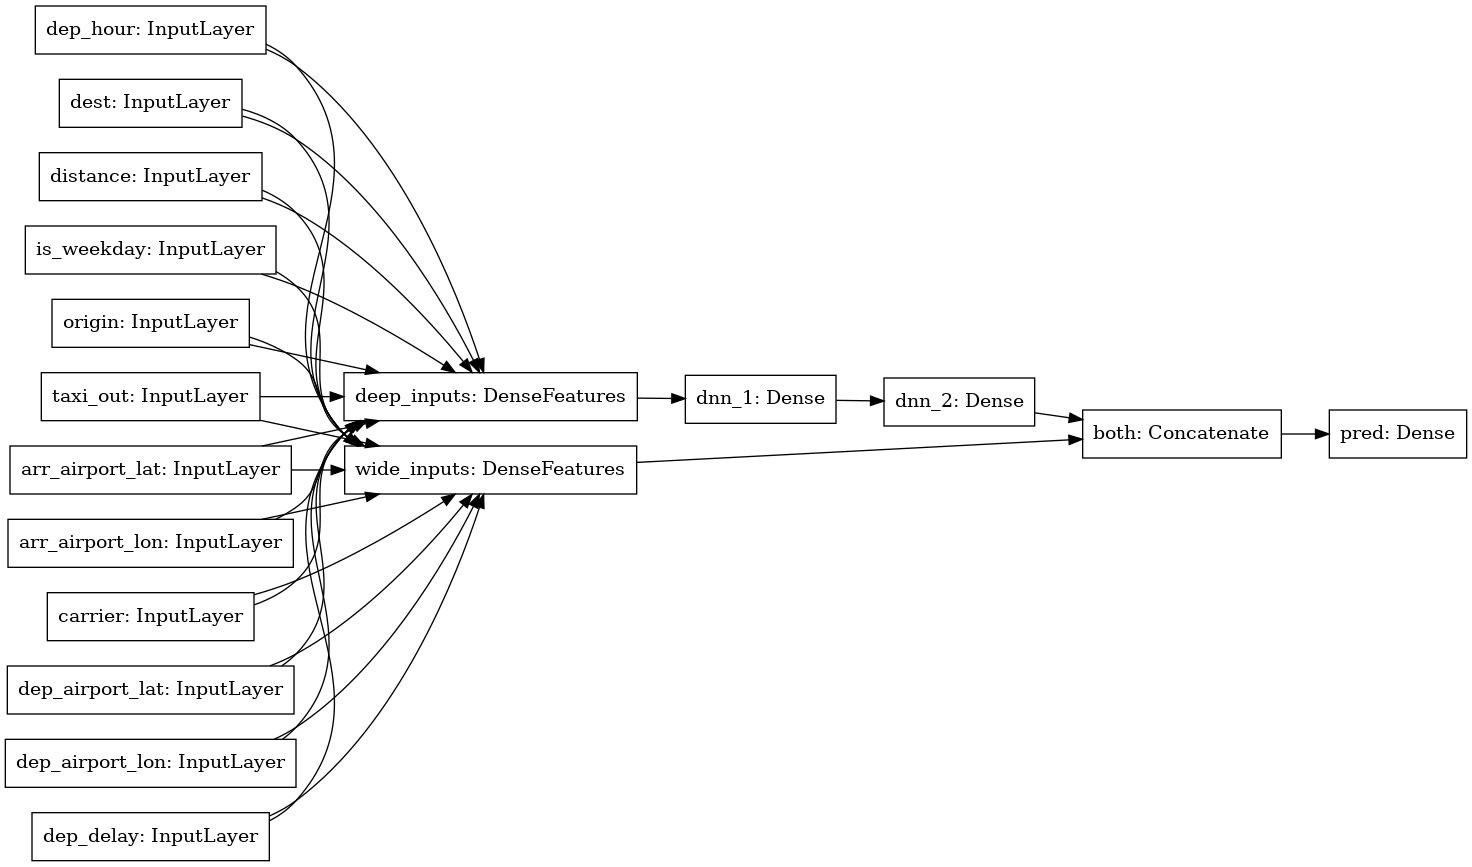

In [15]:
# Build a wide-and-deep model.
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')

You should see:
<img src="flights_model.png"/>

In [16]:
# training and evaluation dataset
train_batch_size = TRAIN_BATCH_SIZE
if DEVELOP_MODE:
    eval_batch_size = 100
    steps_per_epoch = 3
    epochs = 2
    num_eval_examples = eval_batch_size*10
else:
    eval_batch_size = 10000
    steps_per_epoch = NUM_EXAMPLES // train_batch_size
    epochs = 10
    num_eval_examples = None # full dataset
train_dataset = read_dataset(training_data_uri, train_batch_size)
eval_dataset = read_dataset(validation_data_uri, eval_batch_size, tf.estimator.ModeKeys.EVAL, num_eval_examples)

checkpoint_path = '{}/checkpoints/flights.cpt'.format(output_dir)
shutil.rmtree(checkpoint_path, ignore_errors=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_dataset, 
                    validation_data=eval_dataset,
                    epochs=epochs, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[cp_callback])

Epoch 1/2
3/3 [==============================] - 11s 3s/step - loss: 2.0031 - accuracy: 0.8177 - val_loss: 1.5057 - val_accuracy: 0.8215

Epoch 00001: saving model to gs://ai-analytics-solutions-dsongcp/ch9/trained_model/checkpoints/flights.cpt
Epoch 2/2
3/3 [==============================] - 5s 3s/step - loss: 1.0961 - accuracy: 0.7552 - val_loss: 0.9214 - val_accuracy: 0.7985

Epoch 00002: saving model to gs://ai-analytics-solutions-dsongcp/ch9/trained_model/checkpoints/flights.cpt


In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


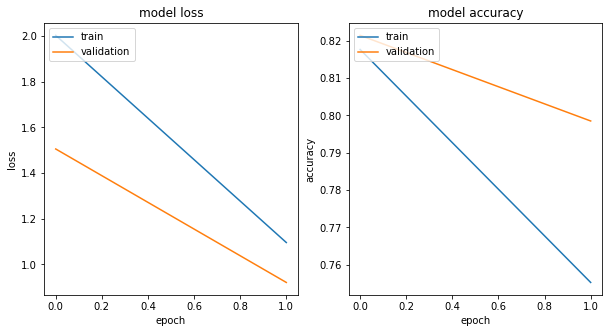

In [18]:
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Export the trained model

In [19]:
import time
export_dir = '{}/export/flights_{}'.format(output_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(model, export_dir)

Exporting to gs://ai-analytics-solutions-dsongcp/ch9/trained_model/export/flights_20211102-064013


2021-11-02 06:40:16.015008: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://ai-analytics-solutions-dsongcp/ch9/trained_model/export/flights_20211102-064013/assets


In [20]:
%%bash
model_dir=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $model_dir
saved_model_cli show --tag_set serve --signature_def serving_default --dir $model_dir

gs://ai-analytics-solutions-dsongcp/ch9/trained_model/export/flights_20211102-064013/
The given SavedModel SignatureDef contains the following input(s):
  inputs['arr_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lat:0
  inputs['arr_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lon:0
  inputs['carrier'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_carrier:0
  inputs['dep_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lat:0
  inputs['dep_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lon:0
  inputs['dep_delay'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_delay:0
  inputs['dep_hour'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_hour:0

## Deploy model to Vertex AI

This will take several minutes.  Bash in Jupyter doesn't provide intermediate output.

You can check progress by visiting https://console.cloud.google.com/vertex-ai/endpoints
and https://console.cloud.google.com/vertex-ai/models

In [22]:
%%bash
# note TF_VERSION and ENDPOINT_NAME set in 1st cell
# TF_VERSION=2-6
# ENDPOINT_NAME=flights

TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH

if [[ $(gcloud ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    # create model
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi

ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"

# delete any existing models with this name
for MODEL_ID in $(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done

# upload model
gcloud beta ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH
MODEL_ID=$(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"

# deploy model to endpoint
gcloud ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=n1-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100


gs://ai-analytics-solutions-dsongcp/ch9/trained_model/export/flights_20211102-064013/
Creating Endpoint for flights-20211102-064051
ENDPOINT_ID=793486755440361472
MODEL_ID=3935868997391613952


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [1674467560977858560]...
....................done.
Created Vertex AI endpoint: projects/379218021631/locations/us-central1/endpoints/793486755440361472.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [3336295823477571584]...
..................done.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [4957591689330950144]...
...................................................................................................................................................................................................................................................................

In [23]:
%%writefile example_input.json
{"instances": [
  {"dep_hour": 2, "is_weekday": 1, "dep_delay": 40, "taxi_out": 17, "distance": 41, "carrier": "AS", "dep_airport_lat": 58.42527778, "dep_airport_lon": -135.7075, "arr_airport_lat": 58.35472222, "arr_airport_lon": -134.57472222, "origin": "GST", "dest": "JNU"},
  {"dep_hour": 22, "is_weekday": 0, "dep_delay": -7, "taxi_out": 7, "distance": 201, "carrier": "HA", "dep_airport_lat": 21.97611111, "dep_airport_lon": -159.33888889, "arr_airport_lat": 20.89861111, "arr_airport_lon": -156.43055556, "origin": "LIH", "dest": "OGG"}
]}

Overwriting example_input.json


In [24]:
%%bash
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo $ENDPOINT_ID
gcloud ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=example_input.json

793486755440361472
[[0.228779882], [0.766132474]]


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]


In [25]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})

curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:predict"

{
  "predictions": [
    [
      0.228779882
    ],
    [
      0.766132474
    ]
  ],
  "deployedModelId": "2339101036930662400",
  "model": "projects/379218021631/locations/us-central1/models/3935868997391613952",
  "modelDisplayName": "flights-20211102-064051"
}


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   809    0   266  100   543   1773   3620 --:--:-- --:--:-- --:--:--  5393


Copyright 2016-2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License